In [1]:
# ------------------ IMPORTS ------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # CNN backbones shiz
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torchmetrics
import wandb
import pandas as pd
import numpy as np
import time
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import shutil
import random
from pathlib import Path
from tabulate import tabulate

c:\Users\neved\sendhelp\plant-leaf-disease-classifier\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------------------ DEVICE CONFIG ------------------
# using CUDA rn coz 3050 lol
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")


Using device: cuda


In [3]:
# ------------------ SPLITTING ------------------

def split_dataset(
    src_dir,
    out_dir="data",
    train_ratio=0.6,
    val_ratio=0.3,
    test_ratio=0.1,
    img_extensions=(".jpg", ".jpeg", ".png"),
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, (
        "Ratios must sum to 1"
    )
    random.seed(42)

    src_dir = Path(src_dir)
    out_dir = Path(out_dir)
    class_dirs = [d for d in src_dir.iterdir() if d.is_dir()]

    for cls_path in class_dirs:
        cls_name = cls_path.name
        images = [f for f in cls_path.glob("*") if f.suffix.lower() in img_extensions]

        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)

        splits = {
            "train": images[:n_train],
            "val": images[n_train : n_train + n_val],
            "test": images[n_train + n_val :],
        }

        for split, files in splits.items():
            split_dir = out_dir / split / cls_name
            split_dir.mkdir(parents=True, exist_ok=True)
            for file in files:
                shutil.copy(file, split_dir / file.name)

        print(
            f"{cls_name}: {n} images train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}"
        )



raw_data_path = "data/raw"
final_output_path = "data"

split_dataset(
    src_dir=raw_data_path,
    out_dir=final_output_path,
    train_ratio=0.6,
    val_ratio=0.3,
    test_ratio=0.1,
)


Apple_Black_Rot: 621 images train=372, val=186, test=63
Apple_Cedar_Rust: 275 images train=165, val=82, test=28
Apple_Healthy: 1645 images train=987, val=493, test=165
Apple_Scab: 630 images train=378, val=189, test=63


In [4]:
# ------------------ PATHS AND HYPERPARAMETERS ------------------
DATA_ROOT = "./data"  # this one has all the data 
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")
TEST_DIR = os.path.join(DATA_ROOT, "test")

# basic training parameters, tweak these for fun 
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50


In [5]:
#------------------ WANDB INITIALISATION ------------------
wandb.init(
    project="cnn-hybrid-transformer",  # Name of your project
    config={                     # Log hyperparameters
        "learning_rate": LEARNING_RATE,
        "architecture": "HybridCNNTransformer",
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "image_size": IMG_SIZE,
    }
)

wandb: Currently logged in as: nevedya-gwalani2024 (eshaan-rithesh2023-vit-chennai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
# ------------------ DATA AUGMENTATION AND DATALOADERS ------------------
# adding transforms to add variety 
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    ]
)

# center crop and resize
val_test_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    # basically representing them on a scale of 0 to 1
)

# image loading datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

# shuffling and creating pockets using some dataloader shi
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

class_names = train_dataset.classes
print(f"Classes found: {class_names}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")


Classes found: ['Apple_Black_Rot', 'Apple_Cedar_Rust', 'Apple_Healthy', 'Apple_Scab']
Training images: 1902
Validation images: 950
Test images: 319


In [7]:
# ------------------ MODEL DEFINITION ------------------
class HybridCNNTransformer(nn.Module):
    
    """
    Hybrid CNN + Transformer model for image classification.

    - CNN Backbone: EfficientNet-B0 pretrained on ImageNet for feature extraction.
    - Projection: 1x1 convolution to convert CNN features to embeddings for Transformer.
    - Transformer Encoder: stacks multi-head self-attention layers.
    - Classification head: Dense layer on CLS token output for final classes.

    You can customize this model by:
    - Adding dropout or normalization layers after CNN backbone.
    - Altering Transformer encoder parameters (num_layers, nhead, dropout).
    - Modifying classification head with more layers or activation.
    """

    def __init__(self, num_classes):
        super(HybridCNNTransformer, self).__init__()

        # 1. CNN Backbone - remove final classifier, keep feature extractor.
        self.cnn_backbone = timm.create_model(
            "efficientnet_b0", pretrained=False, num_classes=0, global_pool=""
        )
        cnn_feature_dim = self.cnn_backbone.num_features

        # add extra features under this one as discussed in the meeting lol
        # self.norm = nn.BatchNorm2d(cnn_feature_dim)
        # self.extra_conv = nn.Conv2d(cnn_feature_dim, cnn_feature_dim, kernel_size=3, padding=1)
        # self.cnn_dropout = nn.Dropout2d(0.2)

        # 2. Project CNN feature maps into transformer embedding dimension.
        embed_dim = 256
        self.projection = nn.Conv2d(cnn_feature_dim, embed_dim, kernel_size=1)

        # 3. Transformer Encoder setup
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=8, batch_first=True, dropout=0.2
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

        # Learnable [CLS] token prepended to the sequence
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Dropout before classification head
        self.dropout = nn.Dropout(0.5)

        # Final classification layer
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # propagation ✨
        x = self.cnn_backbone(x)
        # referring to the thing above, also add layers here coz why not 
        # x = self.norm(x)
        # x = self.extra_conv(x)
        # x = self.cnn_dropout(x)

        # Project CNN features to transformer dimension
        x = self.projection(x)

        # Flatten spatial dimensions to sequence tokens
        b, c, h, w = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # Shape: (B, Seq_len, Emb_dim)

        # Prepend CLS token to sequence (for global representation)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Transformer Encoder forward pass
        x = self.transformer_encoder(x)

        # Extract CLS token output
        cls_output = x[:, 0]
        cls_output = self.dropout(cls_output)

        # Classification head produces final logits
        output = self.fc(cls_output)
        return output


# saving the model to an object and sending it to the gpu 😈
model = HybridCNNTransformer(num_classes=len(class_names)).to(device)


In [8]:
# ------------------ TRAINING SETUP ------------------
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(
    model.parameters(), lr=LEARNING_RATE
)  # optimiser coming in clutch
best_val_accuracy = 0.0  # this will help in saving the best model, basically a counter

# Initialize metrics from torchmetrics
num_classes = len(class_names)
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(
    device
)
val_precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes).to(
    device
)
val_recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes).to(
    device
)
val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes).to(
    device
)
train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(
    device
)

training_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def colorize(value, thresholds, colors, width=10):
    val_str = f"{value:<{width}.4f}"
    if value < thresholds[0]:
        return f"{colors[0]}{val_str}{RESET}"
    elif value < thresholds[1]:
        return f"{colors[1]}{val_str}{RESET}"
    else:
        return f"{colors[2]}{val_str}{RESET}"


# ANSI color codes
RED = "\033[91m"
YELLOW = "\033[93m"
GREEN = "\033[92m"
CYAN = "\033[96m"
RESET = "\033[0m"

In [ ]:
# ------------------ TRAINING LOOP ------------------

# beg wandb to watch your model
wandb.watch(model, log="all", log_freq=100)

# initialize automatic mixed precision (AMP) scaler for FP16 training
scaler = torch.amp.GradScaler("cuda")

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    # LETS GOOOOOOOOO
    model.train()
    train_loss = 0.0
    train_accuracy.reset()

    # tqdm go brrr
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Train]", leave=False
    )
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # mixed precision magic ✨
        with torch.amp.autocast("cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_accuracy.update(outputs, labels)

        # optional eye candy
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_acc = train_accuracy.compute()
    avg_train_loss = train_loss / len(train_loader)

    # validation fr
    model.eval()
    val_loss = 0.0
    # purge old shit
    val_accuracy.reset()
    val_precision.reset()
    val_recall.reset()
    val_f1.reset()

    # more tqdm brrr
    val_loader_tqdm = tqdm(
        val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Val]", leave=False
    )
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()

            # out with the old, in with the new
            val_accuracy.update(outputs, labels)
            val_precision.update(outputs, labels)
            val_recall.update(outputs, labels)
            val_f1.update(outputs, labels)

    final_acc = val_accuracy.compute()
    final_precision = val_precision.compute()
    final_recall = val_recall.compute()
    final_f1 = val_f1.compute()
    avg_val_loss = val_loss / len(val_loader)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # goated for a reason
    wandb.log(
        {
            "epoch": epoch + 1,
            "train/loss": avg_train_loss,
            "eval/loss": avg_val_loss,
            "eval/accuracy": final_acc,
            "eval/precision": final_precision,
            "eval/recall": final_recall,
            "eval/f1": final_f1,
            "train/accuracy": epoch_train_acc,
        }
    )

    training_history["train_loss"].append(avg_train_loss)
    training_history["val_loss"].append(avg_val_loss)
    training_history["train_acc"].append(epoch_train_acc.cpu().numpy())
    training_history["val_acc"].append(
        final_acc.cpu().numpy()
    )  # final_acc is from validation

    # simple post-epoch print flex

    if epoch == 0:
        table_headers = ["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc", "Val F1", "Time(s)"]
        table_rows = []

    # Colorized values
    colored_train_loss = colorize(avg_train_loss, (0.2, 0.5), (GREEN, YELLOW, RED))
    colored_val_loss = colorize(avg_val_loss, (0.2, 0.5), (GREEN, YELLOW, RED))
    colored_train_acc = colorize(epoch_train_acc, (0.8, 0.95), (RED, YELLOW, GREEN))
    colored_val_acc = colorize(final_acc, (0.8, 0.95), (RED, YELLOW, GREEN))
    colored_val_f1 = colorize(final_f1, (0.8, 0.95), (RED, YELLOW, GREEN))

    # Determine if this epoch is the new best
    if final_acc > best_val_accuracy:
        best_val_accuracy = final_acc
        torch.save(model.state_dict(), "best_model.pth")
        # Highlight epoch number in cyan
        epoch_label = f"{CYAN}{epoch + 1}{RESET}"
    else:
        epoch_label = f"{epoch + 1}"

    # Append formatted row
    table_rows.append([
        epoch_label,
        colored_train_loss,
        colored_val_loss,
        colored_train_acc,
        colored_val_acc,
        colored_val_f1,
        f"{epoch_duration:.2f}"
    ])

    # Clear previous table (to avoid repeated prints)
    print('\033[2J\033[H', end='')

    # Reprint full table
    print(
        "\n"
        + tabulate(
            table_rows,
            headers=table_headers,
            tablefmt="rounded_grid",
            numalign="right",
            stralign="center",
        )
    )

# convert to a pandas obj and save as csv
history_df = pd.DataFrame(training_history)
history_df.to_csv("results/training_history.csv", index_label="epoch")



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
╰─────────┴──────────────┴────────────┴─────────────┴───────────┴──────────┴───────────╯



╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.


╭─────────┬──────────────┬────────────┬─────────────┬───────────┬──────────┬───────────╮
│   Epoch │   Train Loss │   Val Loss │   Train Acc │   Val Acc │   Val F1 │   Time(s) │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       1 │       1.2348 │     0.8343 │      0.4774 │    0.6589 │   0.6589 │     44.38 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       2 │       0.9084 │     0.8252 │      0.6299 │    0.6979 │   0.6979 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       3 │       0.8061 │     0.7754 │      0.6788 │    0.6842 │   0.6842 │     25.72 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       4 │       0.6842 │     0.5891 │      0.7161 │    0.7811 │   0.7811 │     25.81 │
├─────────┼──────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┤
│       5 │       0.

In [10]:
# # ------------------ FINAL TESTING & REPORT ------------------
# print("--- Loading best model for final testing ---")
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()

# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Classification metrics report
# print("Classification Report (Test Set):")
# print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# # Confusion matrix heatmap
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=class_names,
#     yticklabels=class_names,
# )
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (Test Set)")
# plt.show()


Final Evaluation on Test Set


wandb: Network error (ConnectionError), entering retry loop.


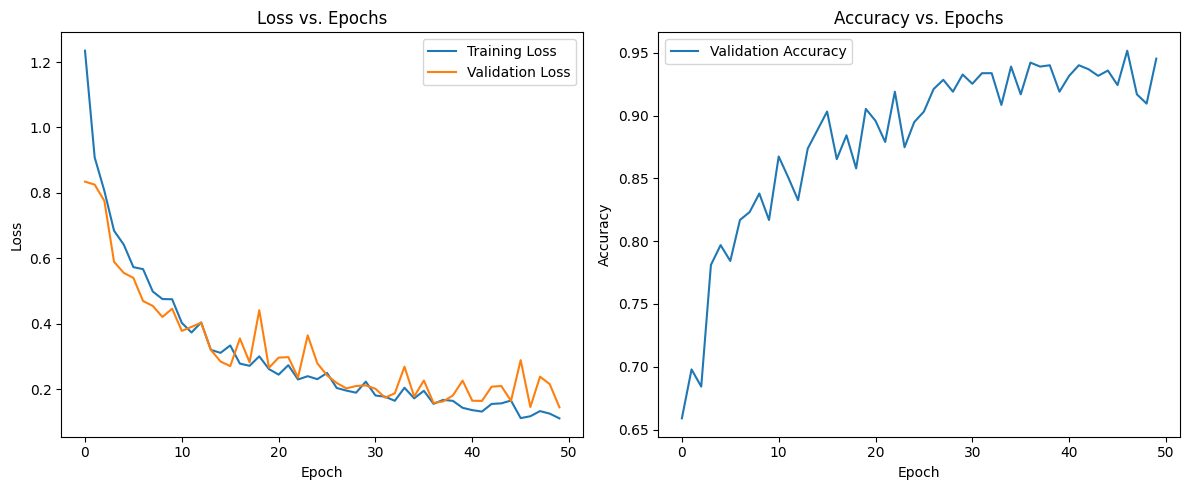

--- Classification Report (Test Set) ---
                  precision    recall  f1-score   support

 Apple_Black_Rot     0.9118    0.9841    0.9466        63
Apple_Cedar_Rust     1.0000    1.0000    1.0000        28
   Apple_Healthy     0.9689    0.9455    0.9571       165
      Apple_Scab     0.9032    0.8889    0.8960        63

        accuracy                         0.9467       319
       macro avg     0.9460    0.9546    0.9499       319
    weighted avg     0.9474    0.9467    0.9467       319

--- Generating Confusion Matrix ---


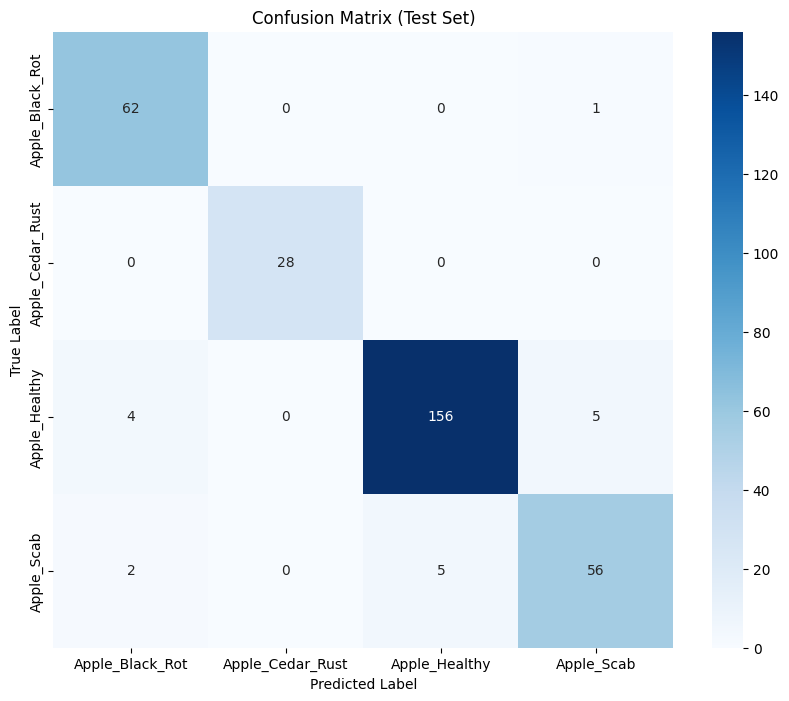

--- Inference ---
Average inference time per image: 5.3190 ms
--- Generating ROC and PR Curves ---


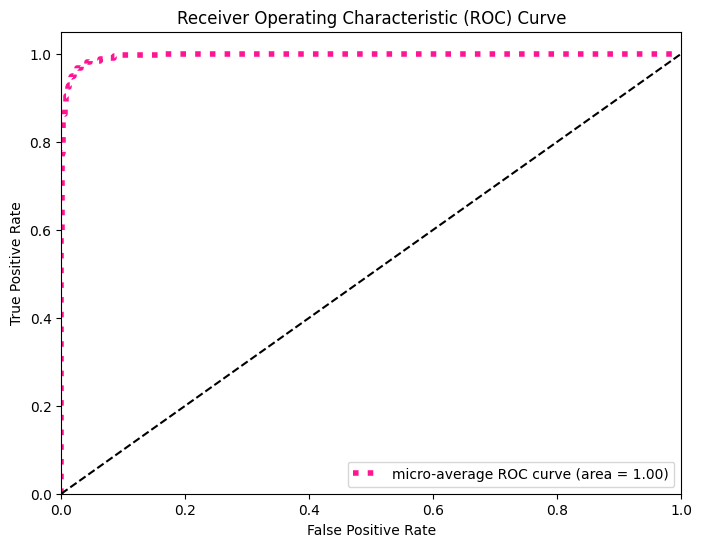

--- Generating t-SNE plot of feature embeddings ---
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 319 samples in 0.000s...
[t-SNE] Computed neighbors for 319 samples in 2.260s...
[t-SNE] Computed conditional probabilities for sample 319 / 319
[t-SNE] Mean sigma: 2.873142
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.281055
[t-SNE] KL divergence after 1000 iterations: 0.192424


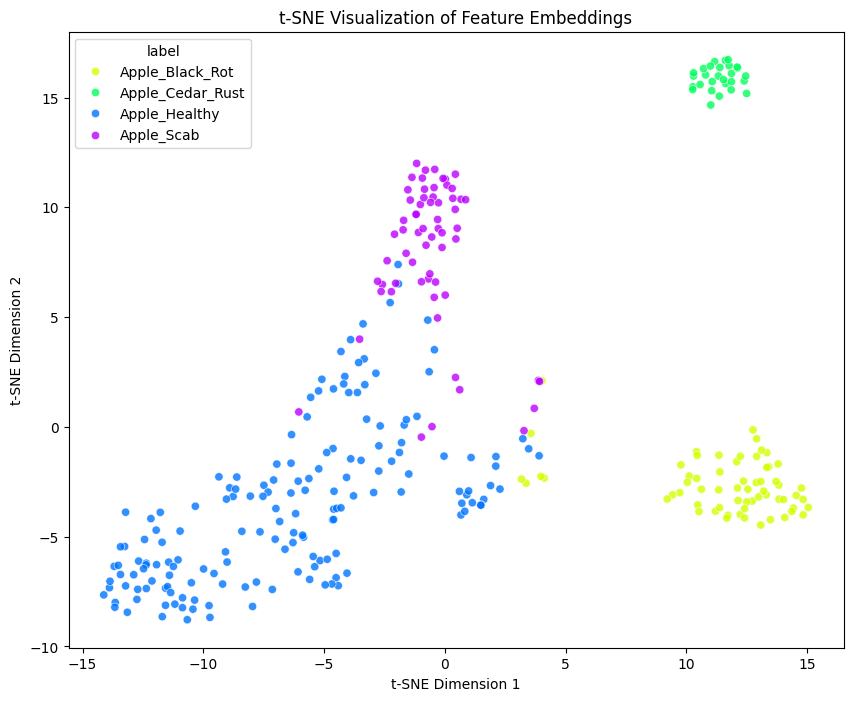

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


--- All artifacts generated and saved in the 'results' folder! ---


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/accuracy,▁▂▄▄▄▅▅▅▆▅▆▇▆▆▆▇▆▇▆▇▇▇▇█▇█▇█▇██▇████▇█▇█
eval/f1,▁▂▂▄▅▅▅▆▆▅▆▇▆▆▆▇▆▇▆▇▇▇▇█▇█▇█▇██▇████▇█▇█
eval/loss,██▇▆▅▄▄▄▄▃▄▃▂▂▃▄▂▃▃▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▂▁▂▁▂▁
eval/precision,▁▂▂▄▄▅▅▅▆▆▆▆▇▆▆▇▆▇▆▇▇▇▇█▇█▇█▇██▇████▇█▇█
eval/recall,▁▁▄▄▄▅▄▆▅▅▆▇▆▆▆▇▆▇▆▇▇▇▇█▇█▇█▇██▇▇███▇█▇█
train/accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train/loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
eval/accuracy,0.94526
eval/f1,0.94526


In [11]:
# ------------------ FINAL TESTING, REPORTING & PLOTTING ------------------
print("Final Evaluation on Test Set")

# saving results here
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Load the best model saved during training
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# --- A. Data Collection from Test Set ---
all_preds = []
all_labels = []
all_probs = []
inference_times = []

# This hook will capture the output of the layer before the final classifier
feature_embeddings = []

def hook(module, input, output):
    feature_embeddings.append(output.detach().cpu().numpy())

# Attach the hook to the dropout layer right before the final `self.fc` layer
hook_handle = model.dropout.register_forward_hook(hook)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        start_time = time.time()
        outputs = model(inputs)
        end_time = time.time()

        inference_times.append(
            (end_time - start_time) / inputs.size(0)
        )  # Time per image in batch

        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Important: Remove the hook after use
hook_handle.remove()

# Convert lists to numpy arrays for easier processing
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_embeddings = np.concatenate(feature_embeddings, axis=0)


# --- B. Generate and Save Artifacts ---

# 1. Training & Validation Curves (vs. Epoch)
history_df = pd.read_csv(f"{output_dir}/training_history.csv")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df["epoch"], history_df["train_loss"], label="Training Loss")
plt.plot(history_df["epoch"], history_df["val_loss"], label="Validation Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(history_df['epoch'], history_df['train_acc'], label='Training Accuracy') # Uncomment if you tracked it
plt.plot(history_df["epoch"], history_df["val_acc"], label="Validation Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/training_curves.png")
wandb.log({"charts/training_curves": wandb.Image(f"{output_dir}/training_curves.png")})
plt.show()

# 2. Classification Report and Test Metrics
print("--- Classification Report (Test Set) ---")
report = classification_report(
    all_labels, all_preds, target_names=class_names, digits=4
)
print(report)
with open(f"{output_dir}/classification_report.txt", "w") as f:
    f.write(report)

# Save detailed metrics to a CSV file
report_dict = classification_report(
    all_labels, all_preds, target_names=class_names, output_dict=True, digits=4
)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(f"{output_dir}/classification_metrics.csv")
wandb.log({"tables/classification_metrics": wandb.Table(dataframe=report_df)})

# 3. Confusion Matrix
print("--- Generating Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.savefig(f"{output_dir}/confusion_matrix.png")
wandb.log(
    {"charts/confusion_matrix": wandb.Image(f"{output_dir}/confusion_matrix.png")}
)
plt.show()

# 4. Inference Time
avg_inference_time = np.mean(inference_times)
print("--- Inference ---")
print(f"Average inference time per image: {avg_inference_time * 1000:.4f} ms")
wandb.summary["inference_time_ms"] = avg_inference_time * 1000

# 5. ROC and Precision-Recall Curves (for multi-class)
print("--- Generating ROC and PR Curves ---")
y_true_binarized = label_binarize(all_labels, classes=np.arange(len(class_names)))
n_classes = len(class_names)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (area = {roc_auc['micro']:0.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# You can also plot for each class if you want
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.savefig(f"{output_dir}/roc_curve.png")
wandb.log({"charts/roc_curve": wandb.Image(f"{output_dir}/roc_curve.png")})
plt.show()

# (Optional but recommended) You can log the data to W&B to create interactive plots
# roc_wandb = wandb.plot.roc_curve(y_true=all_labels, y_probas=all_probs, labels=class_names)
# wandb.log({"roc_interactive": roc_wandb})

# 6. t-SNE / PCA Visualization
print("--- Generating t-SNE plot of feature embeddings ---")
tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_results = tsne.fit_transform(all_embeddings)

df_tsne = pd.DataFrame()
df_tsne["tsne-2d-one"] = tsne_results[:, 0]
df_tsne["tsne-2d-two"] = tsne_results[:, 1]
df_tsne["label"] = [class_names[label1] for label1 in all_labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hsv", len(class_names)),
    data=df_tsne,
    legend="full",
    alpha=0.8,
)
plt.title("t-SNE Visualization of Feature Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.savefig(f"{output_dir}/tsne_visualization.png")
wandb.log(
    {"charts/t-sne_visualization": wandb.Image(f"{output_dir}/tsne_visualization.png")}
)
plt.show()

print("--- All artifacts generated and saved in the 'results' folder! ---")

# Remember to call wandb.finish() at the very end of your script
wandb.finish()
